# 【点滴】学习强化学习

## 1 Q-Learning Agent

Q-Learning 方法是强化学习算法家族中的一个经典算法，它有别于目前应用更加广泛的基于策略的强化学习算法，但是是入门强化学习的很好的基础。因此，整个学习路线是：首先弄懂Q-Learning的原理，完成其最基础的实现（look-up table），然后以神经网络为元件实现Q-Learning，再进入policy-based方法的学习，逐渐进入前沿强化学习方法领域。

强化学习中包含两种主流算法，基于策略的算法是直接学习如何将一个状态映射为一个动作；基于状态（动作）价值的算法则是学习每个经历状态的效益值，或者状态-动作对的效益值，然后基于该效益值筛选动作。可以看到，尽管两个方法最终都实现同一个目标——为给定状态选择合适的动作，但它们的完成方式有显著的区别。

### 1.1 基于Q-Table的方法

本小节将首先以OpenAI Gym提供的[FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/)环境为研究案例。OpenAI Gym提供了一系列简单的强化学习应用场景，方便人们测试自己的算法。在Frozen Lake中，智能体将被放入一个4\*4的网格阵，每个网格对应一定的特性：

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*MCjDzR-wfMMkS0rPqXSmKw.png">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">FrozenLake环境示意图</div>
</center>

智能体在该环境的学习目标是：从起始方块（S）出发，到达目标方块（G），过程中可以经过安全方块（F），但需要避免进入危险方块（H）。智能体每一步都可以选择上下左右其中一个方向前进，但有一定概率受到“风”的影响，导致随机前进到一个方块。因此，不可能每次都完成最优的出行，但学习如何安全到达安全方块是可行的。在该环境中，每一步前进的奖赏都是0，唯有到达目标方块后获得奖赏1。

Frozen Lake可以说是一个最基础的强化学习体验案例，因为它的起始状态与终止状态都固定，且状态空间（一维16个取值）与动作空间（一维4个取值：上/下/左/右）足够小。

最简单的Q-Learning实现方式是构造一个记录状态-动作对价值的表格（Q-Table）。在该表格中，每行代表一个状态，每列代表一个动作。在Frozen Lake这个案例中，Q-Table大小是16\*4，即需要学习出16\*4个状态-动作对的价值，最后根据这些价值选择合适的动作。首先，需要将Q-Table所有值初始化为0，然后根据智能体在该环境的经历，不断更新Q-Table的各个值。采用经典的[Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) 去更新表格：以下是基于Q-Table的Q-Learning实现：

**Eq(1)**: $ Q(s,a)=r+\lambda (\mathop {\max }\limits_{a'} (Q(s',a')))$

其中，
$Q(s,a)$表示状态-动作对（s，a）的收益；r表示在状态s执行动作a的即时奖赏；$Q(s',a')$ 表示在状态s执行动作a后到达下一状态的收益；$\lambda$是折扣系数，允许我们确定当前奖赏和未来收益之间的重要性。上式说明的是，**当前状态-动作对（s，a）的期望收益等于当前获得的奖赏加上最好的长期效益**。这种更新方法使得每一次更新都重新使用了之前的更新结果，是一个迭代的过程。



In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake-v0')

[[1.67500456e-04 9.78456330e-02 2.72223444e-04 3.37446997e-04]
 [1.04062086e-05 1.66738822e-05 1.81889254e-05 4.49573617e-02]
 [2.03219302e-05 1.18330181e-04 2.43686809e-05 1.18771185e-02]
 [1.21114558e-05 1.37007786e-05 7.37863675e-06 2.99169155e-03]
 [1.12936257e-01 7.53579829e-05 5.56291827e-05 2.27711092e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.26176016e-07 2.80480342e-08 1.01975389e-02 3.15001685e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.71615877e-06 6.17120549e-05 3.50345412e-05 1.17501844e-01]
 [6.05794953e-05 4.85933341e-01 3.14152940e-05 3.00864925e-05]
 [6.40997119e-02 3.92317816e-06 1.52894792e-07 4.17809373e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.84368982e-05 0.00000000e+00 9.98625765e-02 1.20424407e-03]
 [0.00000000e+00 0.00000000e+00 9.63185330e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

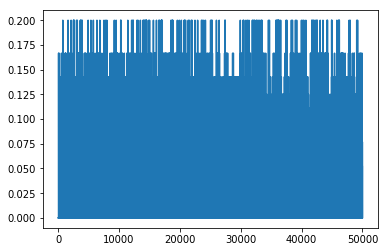

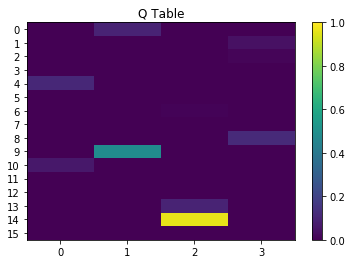

In [50]:
Qt = np.zeros([env.observation_space.n,env.action_space.n])

lr = 0.9
lam = 0.95
num_episodes = 50000
rAlllist=[]
for i in range(num_episodes):
    s = env.reset()
    j = 0
    max_steps_in_episode = 99
    rAll=0.
    
    while j<max_steps_in_episode:
        # action[0:Left ## 1:Down ## 2:Right ## 3:Up]
        if i<48000:
            a = np.argmax(Qt[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        else:
            a = np.argmax(Qt[s,:])
        s_next, r, d,_ = env.step(a)
        Qt[s,a] = Qt[s,a] + lr*(r+lam*np.max(Qt[s_next,:])-Qt[s,a])
        s = s_next
        rAll+=r
        if d==True:
            break
        j+=1
    rAlllist.append(rAll/j)
    
print(Qt)
plt.figure(1)
plt.plot(rAlllist)
plt.figure(2)
plt.title('Q Table')       
plt.xticks(np.arange(0,env.action_space.n,1.0))
plt.yticks(np.arange(0,env.observation_space.n,1.0))
plt.imshow(Qt, interpolation='none',aspect='auto')
plt.colorbar()
plt.clim(0,1)
plt.show()

[[67. 57. 55. 39.]
 [70.  0. 36.  0.]
 [72. 73. 35.  0.]
 [ 0. 74. 76. 77.]]


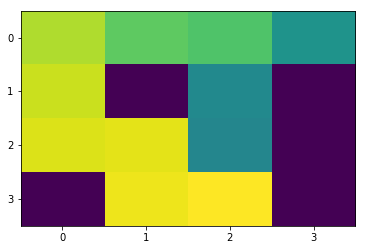

In [63]:
%matplotlib qt5
s = env.reset()
route=np.zeros([4,4])
if s_next<4:
    i=0
    j=s_next
else:
    i = int(s_next/4)
    j = s_next%4
route[i,j]=1
step=1
d=False
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()
# 在线绘制agent移动路线
while d==False:
    ax.clear()
    plt.xticks(np.arange(0,4,1.0))
    plt.yticks(np.arange(0,4,1.0))
    ax.imshow(route, interpolation='none',aspect='auto')
    fig.canvas.draw()
    plt.pause(0.3)
    a = np.argmax(Qt[s,:])
    s_next, r, d,_ = env.step(a)
    step+=1
    if s_next<4:
        i=0
        j=s_next
    else:
        i = int(s_next/4)
        j = s_next%4
    route[i,j]=step
    s = s_next

print(route)

### 1.2 基于Q-Network的方法

很容易可以想到：当状态空间和动作空间非常大时，Q-Table往往要求庞大的存储空间，且不够灵活，为了降低存储消耗，我们可以通过构造一个函数去估计Q-Table，神经网络是一个常见且有效的选择，利用神经网络去充当估计器，我们可以通过构造（特征）向量表示任意状态，生成神经网络的输入，然后让网络学习状态对应的效益值。

在本小节的案例中，我们可以通过one-hot向量去描述(输入)状态：: $s\in R^{1x16}$,而对应的输出则是该状态下，执行每个可选动作的效益值：$Q\in R^{1x4}$。在神经网络中，我们通过梯度下降优化损失函数的方式进行“Q-Table”的更新学习，对应的损失函数为：

**Eq(2)**: $Loss=\sum (Q_{target}-Q_{estimate})^2$

$Q_{target}=r+\lambda (\mathop {\max }\limits_{a'} (Q_{estimate}(s',a'))))$

实际上，在处理FrozenLake问题时，神经网络并不比Q-Table方法来的多高效。同时需要指出，尽管利用神经网络拟合Q值为描述Q值带来了更大的灵活性，但该方法在进行Q-Learning时稳定性不佳，收敛花费时间较长。当下有大量基于神经网络进行Q-Learning的扩展研究，目的就是为了寻求一个更好更稳定的Q值估计结果，在这些研究中，尤为著名的是[Atari-playing Deep Q-Networks](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)中提出的**Experience Replay**和**冻结目标网络** ：

**Experience Replay**

在智能体与环境交互时，存储每次的经历$<s,a,r,s'>$，存储点记为replay memory。在训练Q神经网络时，在replay memory中随机采样出经历，而非使用最近的经历。这样的做法可以打破每批训练样本的相似性，以免网络过早陷入局部最优。同时，Experience Replay的使用让学习过程与一般的监督学习更为相似，这也一定程度简化了算法的调试流程，特别地，我们甚至可以人工收集经历，然后再让智能体学习。

**冻结目标网络**

在公式2中，损失函数中的目标值$Q_{target}=r+\lambda (\mathop {\max }\limits_{a'} (Q_{estimate}(s',a'))))$需要估计，冻结目标网络实质上是通过构造一个与原训练神经网络构造完全一样的“目标网络”去完成这个估计。具体来说，每当原训练神经网络的参数更新了一段时间，我们就将该套参数加载到“目标网络”，在更新原训练神经网络时，用“目标网络”去估计目标值。这一做法相比于传统的在线Q-Learnig会使训练更加稳定，因为在以往的在线Q-Learning中，网络更新会立即影响$Q_{target}$，很可能会导致策略的振荡甚至发散，冻结目标网络使得目标值的估计可以稳定一段时间，使得策略学习更不易发散。

**Q-Network Approach in Tensorflow**

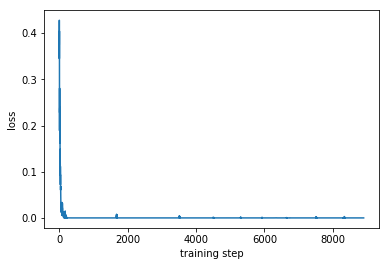

In [47]:
import tensorflow as tf

def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

state_dim_ = env.observation_space.n
action_dim_ = env.action_space.n

class DQN():
    def __init__(self, sess, state_dim, action_dim=1, lamda=0.95, updateStep=10, output_num=4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state = tf.placeholder(tf.float32,[None,self.state_dim],name='state')
        self.next_state = tf.placeholder(tf.float32,[None,self.state_dim],name='next_state')
        self.action = tf.placeholder(tf.float32,[None,self.action_dim],name='state')
        self.reward = tf.placeholder(tf.float32,[None, 1], name='reward')
        self.lamda = lamda
        self.updateStep = updateStep
        self.output_num = output_num
        self.sess = sess
    
    def buildQNetwork(self,):
        
        with tf.variable_scope('update-Qnetwork'):
            w1 = weight_variable([self.state_dim,self.output_num])
            b1 = bias_variable([self.output_num])
            
        with tf.variable_scope('target-Qnetwork'):
            w1_ = weight_variable([self.state_dim,self.output_num],train=False)
            b1_ = bias_variable([self.output_num],train=False)
                                
        self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Qnetwork')
        self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Qnetwork')
                                
        self.Qset = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.targetQset = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.reward+self.targetQset*self.lamda, self.Qset))
        self.a = tf.argmax(self.Qset,1)
        
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.01).minimize(self.loss)
    
    def learn(self,step,memory):#stateBacth, actionBatch, rewardBatch, nextStateBatch
        
        _, loss = self.sess.run([self.trainOp,self.loss], feed_dict={self.state : memory[:,0:self.state_dim], self.action : memory[:,self.state_dim].reshape(-1,1),
                                              self.reward : memory[:,self.state_dim+1].reshape(-1,1), self.next_state : memory[:,-self.state_dim:]})
        
        if step%self.updateStep==0:
            # update tar by (1.-0.01)*tar + 0.01*eva
            self.sess.run([tf.assign(tar, (1.-0.01)*tar + 0.01*eva) for tar, eva in zip(self.t_params, self.e_params)])
        return loss
    
    def choose_action(self,state):
        return self.sess.run(self.a, feed_dict={self.state:state})
        
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+action_dim+1))  
        self.pointer = 0
        
    def store_experience(self, state, action, reward, next_sate):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state, action, reward, next_sate))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return memory_batch        
    
    
tf.reset_default_graph()
sess_ = tf.Session()
model = DQN(state_dim=state_dim_, lamda=0.95,updateStep=10, sess=sess_)
model.buildQNetwork()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)

M = replay_memory(memory_capacity=128, state_dim=state_dim_)
batch_size_ = 32
num_episodes = 500

records = 0
loss_set=[]
for i in range(num_episodes):
    s = env.reset()
    j = 0
    max_steps_in_episode = 99
    while j<max_steps_in_episode:
        state_vector = np.zeros([1,state_dim_])
        nextSate_vector = np.zeros([1,state_dim_])
        state_vector[0,s]=1
        a = model.choose_action(state=state_vector)
        s_next, r, d,_ = env.step(a[0])
        nextSate_vector[0,s_next]=1
        
        reward=np.array(r).reshape(1,1)
        
        M.store_experience(state=state_vector, action=np.array(a).reshape(1,1), reward=np.array(r).reshape(1,1), next_sate=nextSate_vector)
        
        j+=1
        records+=1
        
        if records>M.memory_capacity:
            memory_batch = M.replay(batch_size=batch_size_)
            loss_ = model.learn(records,memory=np.array(memory_batch) )
            loss_set.append(loss_)
        if d==True:
            break

plt.plot(loss_set)
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

In [50]:
Qtable=np.zeros((state_dim_, action_dim_))
for i in range(state_dim_):
    state_vector=np.zeros([1,state_dim_])
    state_vector[0,i] = 1
    Q_ = sess_.run(model.Qset, feed_dict={model.state:state_vector})
    Qtable[i,:]=np.array(Q_[0])

print(Qtable)

[[ 0.2373638   0.17330158 -0.13279152 -0.21077365]
 [ 0.3162412  -0.04182023 -0.62010187 -0.32224095]
 [ 0.07921799 -0.29625273 -0.16530985 -0.2556535 ]
 [ 0.20199314  0.0346947  -0.44751608  0.17124237]
 [ 0.46219882  0.26055557 -0.40123969 -0.07045317]
 [ 0.4294745   0.36401945 -0.26201755  0.12366693]
 [ 0.35229126  0.38378638 -0.54476321 -0.21351653]
 [-0.00852311 -0.24345529  0.55759662 -0.50474918]
 [ 0.03486028  0.51303446  0.91330451 -0.46845514]
 [ 0.36114416  0.3814961   0.00761066 -0.1062001 ]
 [ 0.31450063 -0.12834334  0.24177049 -0.18782645]
 [ 0.39869243  0.71143323 -0.42219681 -0.39107198]
 [ 0.16276333  0.47621256  0.0735338   0.17801365]
 [ 0.37008095 -0.54096818  0.35454586 -0.03328127]
 [ 0.44521427 -0.21963626  0.83468562 -0.24551922]
 [ 0.47466582 -0.47779852  0.43994406  0.90818107]]


In [53]:
%matplotlib qt5
s = env.reset()
route=np.zeros([4,4])
if s_next<4:
    i=0
    j=s_next
else:
    i = int(s_next/4)
    j = s_next%4
route[i,j]=1
step=1
d=False
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()
# 在线绘制agent移动路线
while d==False:
    ax.clear()
    plt.xticks(np.arange(0,4,1.0))
    plt.yticks(np.arange(0,4,1.0))
    ax.imshow(route, interpolation='none',aspect='auto')
    fig.canvas.draw()
    plt.pause(0.3)
    
    state_vector=np.zeros([1,state_dim_])
    state_vector[0,s] = 1
    a = sess_.run(model.a, feed_dict={model.state:state_vector})
    s_next, r, d,_ = env.step(a[0])
    step+=1
    if s_next<4:
        i=0
        j=s_next
    else:
        i = int(s_next/4)
        j = s_next%4
    route[i,j]=step
    s = s_next

print(route)

[[10.  0.  0.  0.]
 [13.  0.  0.  0.]
 [16. 15.  0.  0.]
 [17.  0.  0.  0.]]


### 参考资料

[1][Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

[2][DEMYSTIFYING DEEP REINFORCEMENT LEARNING](https://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/)

[3][Convergence of Q-Learning: a simple proof](http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf)

## 2 Policy-based Agent 

## 2.1 Two-armed Bandit

强化学习使得我们不仅得以教一个智能体如何工作，并允许智能体通过与环境的交互自行学习如何工作。深度神经网络借助目的导向学习的智能体，可以学习到复杂的环境表达信息，结合学习到的表达，计算机取得了一些令人惊叹的成就，包括[在Atari games上击败人类](https://deepmind.com/research/dqn/)以及[击败围棋冠军](https://deepmind.com/research/alphago/)。

学习如何构造这些智能体要求我们从监督学习的工作思路中转变过来。那种找个算法去匹配某些确定刺激和其响应的能力已经不再靠谱了，相反，强化学习算法必须能够使智能体基于“环境状态”，“即时奖赏”以及“动作”这几个元素，自主去获取并学习到合适的输入输出关系。此时，现在无论在何种场景，我们不再能告诉智能体理应执行的所谓的正确的行为，因此，问题相对更加复杂。

本小节将以新的一个小问题来探索强化学习——n-armed bandit，也就是n个摇杆的老虎机，每个摇杆都对应固定的选择几率。这个游戏的目标是摸索出这个老虎机最优的摇杆选择几率组合，即一种投币策略，来最大化每次执行该策略获取的奖赏。现在我们先进一步简化这个问题，研究对象选为一个两个摇杆的老虎机。事实上，这个简化后的问题也太简单了，就姑且将它视为更多是一个解决实际强化学习问题的探路者。

需要强调的是，被视为强化学习问题的任务会具备以下典型的特点：

- 不同的动作决策对应不同的即时奖赏。打个比方，当在一个迷宫寻宝时，在某个位置向右走得到宝藏，向左走遇见陷阱。

- 考虑奖赏的前瞻性。即考虑将来可能发生的奖赏，在我们到达向右走就可以得到宝藏的位置前，我们应首先认识到走到该位置是诱人的。

- 动作决策的奖赏是基于所处的状态的。在某个位置执行的动作，获取了好的奖赏，在另一个位置执行相同的动作却不一定同样获得好的回报。

此次的案例是一个非常简单的开始，它不考虑所处的状态（每次都一样），也不考虑长远收益（前后两个动作相互独立），即忽略了后两个要素。我们需要关注的仅仅是去认识每个动作对应的可能的奖赏，并学习如何去最大化获得的奖赏，如何实现这个目标以强化学习的术语来表达就是策略（policy）——现在我们关注policy-based agent，相比于Q-Learning **“环境$\rightarrow$Q value$\rightarrow$动作”**的工作模式，现在的思路是**“环境$\rightarrow$动作”**，也根据就是直接学习环境到动作的映射。这里用到的优化算法是[policy gradient](http://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)：构造接受环境状态输入，输出动作的神经网络作为决策单元，通过智能体与环境的交互推导出优化神经网络权重的梯度，进行权重的更新。

### Policy gradient

本小节主要参考Sutton等人的著作，将从比较数学的角度捋一遍policy gradient：

将根据状态选择动作的策略参数化：

**Eq(3)**:$\pi(a|s,\theta)=Pr\{A_t=a|S_t=s,\theta_{t}=\theta\}$

基于参数化策略，可以定义某策略下，从任意一个状态$s$出发执行策略的期望效益为：

**Eq(4)**：$J(\theta)\dot{=}v_{\pi}(s)=\sum\limits_{s\in S}\mathop {\sum }\limits_{a}\pi(a|s,\theta)Q_{\pi}(s,a)$

其中，$\mu{(s)}= \sum\limits_{k=0}^{\infty}\gamma^{k} Pr(s \rightarrow x,k,\pi)$考虑了从状态$s$出发到任意一个状态$x$的概率及经历的期望步数$k$，表达从状态$s$出发到任意一个状态$x$的的期望折扣。

很自然可以想到用梯度上升的方式优化上式，需要指出的是，策略参数的更新梯度通过执行的动作和对应的奖赏可以比较直截了当地获得，但执行的策略导致的状态转移是基于所处环境的一个未知表达，因此无法计算这方面作用的梯度，幸运的是，Sutton等人已经证明策略的更新梯度计算不需要考虑状态转移函数的梯度，得出简洁的策略梯度定理：

> **Eq(5)**:$\bigtriangledown J(\theta) \propto \mathop {\sum }\limits_{s}\mu{(s)}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)$
,$\mu{(s)}= \sum\limits_{k=0}^{\infty}\gamma^{k} Pr(s \rightarrow x,k,\pi)$


#### Reinforce


把**Eq(5)**视为基于策略$\pi$的期望：

$ \mathop {\sum }\limits_{s}\mu{(s)}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)=E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)]$

简单的变形：

$E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)]=E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)\frac{\pi(a|s,\theta)}{\pi(a|s,\theta)}]=E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown log \pi(a|s,\theta)Q_{\pi}(s,a) {\pi(a|s,\theta)} ]$

由于动作$a$来源于策略$\pi$,既有$A_{t}~\pi$，将动作与状态都视为随机变量，此时上述期望进一步化解：

**Eq(6)**：$\bigtriangledown J(\theta)=E_{\pi}[\gamma^{k} \bigtriangledown log \pi(A_t|S_t,\theta)Q_{\pi}(S_t,A_t)]$

以上即基于策略梯度定理的Reinforce算法，算是策略梯度一类方法的鼻祖，它基于MC的方法进行采样计算梯度，可以看到，为了得到$Q(S_t,A_t)$，每次的MC都需要经历一个完整的episode，故Reinforce只能用于finite-episode的场景，且效率较低，训练方差较大。

#### Reinforce with Baseline

在**Eq(6)**中，为了减少梯度的方差，使得训练更加平稳，让效益值减去baseline使得每次效益值尽可能固定：

$E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)(Q_{\pi}(s,a)-b(s))]$

由于$E_{\pi}[\gamma^{k} \bigtriangledown \pi(A_t|S_t,\theta)b(S_t)]=\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)b(s)=b(s)\bigtriangledown 1=0$，因此这个trick保证了训练稳定性的同时，并不影响梯度的计算。这是Reinforce的一种改进。

#### Actor-Critic

尽管Reinforce with baseline算法实际上是在学习策略和估计状态价值，但它估计状态价值仅充当baseline，因此并不能称为一个critic。换句话说，Actor-Critic和Reinforce with baseline最大的区别就是：critic实现状态价值估计不仅仅为了充当baseline，更重要是实现bootstrapping，即依据接下来的状态估计更新当前的状态估计，更适合在线运行。

### A naive trial : Multi-armed bandit with policy gradient in TensorFlow

In [27]:
# 最简单版本的策略梯度案例
import tensorflow as tf
import numpy as np

bandits = [0.2,0,-0.2,-5]


def pullBandit(bandit):
    result = np.random.randn(1)
    if result>bandit:
        return 1 # positive reward
    else: return -1

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.5)
    return tf.Variable(initial)
    
class agent():
    def __init__(self,):
        self.action = tf.placeholder(tf.int32,[1], name='action')
        self.reward = tf.placeholder(tf.float32,[1], name='reward')
    def buildPolicyNetwork(self, num_bandits):
        self.weight = tf.Variable(tf.ones([num_bandits]))
        self.responsible_weight = tf.slice(self.weight, self.action, [1])
        self.loss = -tf.reduce_mean(self.reward*tf.log(self.responsible_weight))
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.04).minimize(self.loss)
    def choos_action(self,):
        return tf.argmax(self.weight,0)
    
num_episodes = 1000

tf.reset_default_graph()
sess_ = tf.Session()
model = agent( )
model.buildPolicyNetwork(num_bandits=len(bandits))
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)

exploration_prob = 0.1
for i in range(num_episodes):
    if np.random.randn(1)<exploration_prob:
        action = np.random.randint(len(bandits))
    else:
        action = sess_.run(model.choos_action())
    reward = [pullBandit(bandits[action])]
    sess_.run(model.trainOp, feed_dict={model.reward:reward, model.action:[action]})
    if i%100==0:
        print(sess_.run(model.weight))

[1.   1.04 1.   1.  ]
[0.59079117 1.2490311  1.786226   3.3703156 ]
[0.89357394 1.3589152  2.2559717  5.3832917 ]
[0.1792259 1.2719303 2.3610716 6.8748937]
[-0.59942985  0.9029873   2.2593598   8.167424  ]
[-0.21109875  0.71019924  2.6749518   9.356331  ]
[-0.6982591  0.6935626  3.129112  10.754131 ]
[-0.73552233  0.7496382   3.050733   12.075997  ]
[-0.59368587  0.9900622   3.1868832  13.366019  ]
[-0.9071643  0.7517966  3.7111242 14.533899 ]


#### A maturer trial : Cart-Pole task

上述案例展示了不考虑状态影响和长期奖赏时，如何利用策略梯度训练智能体，使其选择奖赏更高的动作。接下来将构造一个更加完满的强化学习智能体，让它既可以感知环境状态，又不仅仅局限于即时奖赏。

在强化学习中，智能体的外界环境可被看作是一个马尔可夫过程（Markov Decision Process）。这种环境提供奖赏以及状态转移作为智能体决策的反馈，值得指出的是，其奖赏基于状态本身以及智能体在该状态下所执行的动作。整个环境的反馈过程是具有时变性的，并有可能存在一定的延时。

更加正式的定义马尔可夫决策过程：

一个马尔科夫过程包含状态集合$S$，这些状态$s$可能被智能体在任意时间经历；包含可行动作集合$A$，其中每个$a$是智能体任意时间可能决策的动作。给的状态-动作对$(s,a)$，可以定义下一状态$s'$的转移概率$T(s,a,s')$，以及即时奖赏$R(s,a)$。基于以上定义，在任意MDP中，智能体接受输入状态$s$，执行动作$a$，到达新的状态$s'$并获取奖赏$r$。

选择OpenAI gym的Cart-Pole案例进行策略梯度的更完善的实验。在该实验中，我们将训练智能体如何保持一跟竖杆的平衡，使之不倒下，该任务包含的强化学习要是如下：

- 输入输出：智能体需要知道竖杆的当前位置，然后推算它平衡时的角度。为了实现这个目标，我们建立的神经网络需要接受输入状态并输出一个动作的概率。

- 延迟奖赏：我们尽可能长时间的保持竖杆平衡，这要求智能体不仅仅考虑当下的奖赏，还应有长远的考虑。为了实现这一点，每一个状态-动作对下的效益值应该是一个引入延迟系数的长期奖赏。

以下将利用**Actor-Critic**解决Cart-Pole:

In [3]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [19]:
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+action_dim+1+1+1+1))   # state, action ,reward ,next state, action index,q，target q
        self.pointer = 0
        
    def store_experience(self, state, action, reward, next_sate,action_index,v_value,target_v):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state, action, reward, next_sate,action_index,v_value,target_v))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return np.array(memory_batch)

In [50]:
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.constant(value=0.1,shape=shape)
    return tf.Variable(initial,trainable=train)

class agent():
    def __init__(self, action_dim=2, state_dim=4 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action = tf.placeholder(tf.float32,[None, action_dim], name='action')
        self.state = tf.placeholder(tf.float32,[None,state_dim], name='state')
        self.next_state = tf.placeholder(tf.float32,[None,state_dim], name='next_state')
        self.reward = tf.placeholder(tf.float32,[None,1], name='reward')
        self.action_index = tf.placeholder(tf.int32, [None], name='a')
        self.V_holder = tf.placeholder(tf.float32, [None,1], name='Qvalue')
        self.targetV =  tf.placeholder(tf.float32, [None,1], name='Target_Qvalue')
        
    def buildCriticNetwork(self,):
        with tf.variable_scope('update-Critic_network'):
            w1 = weight_variable([self.state_dim, 20])
            b1 = bias_variable([20])
            w2 = weight_variable([20, 1])
            b2 = bias_variable([1])
        with tf.variable_scope('target-Critic_network'):
            w1_ = weight_variable([self.state_dim, 20],train=False)
            b1_ = bias_variable([20],train=False)
            w2_ = weight_variable([20, 1],train=False)
            b2_ = bias_variable([1],train=False) 
            
        self.v_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Critic_network')
        self.v_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Critic_network')
 
        h1 = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.V =  tf.identity(tf.matmul(h1, w2)+b2)

        h1_next = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        self.nextV = tf.identity(tf.matmul(h1_next, w2_)+b2_)
        
        self.v_loss = tf.reduce_mean(tf.squared_difference(self.targetV, self.V))
        self.v_trainOp = tf.train.AdamOptimizer(learning_rate=0.1).minimize(self.v_loss)
        
        self.Critic_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.v_t_params, self.v_e_params)]
        
    def buildActorNetwork(self, ):
        with tf.variable_scope('update-Actor_network'):
            w1 = weight_variable([self.state_dim, 20])
            b1 = bias_variable([20])
            w2 =  weight_variable([20, self.action_dim])
            b2 = bias_variable([self.action_dim])
            
        with tf.variable_scope('target-Actor_network'):
            w1_ = weight_variable([self.state_dim, 20],train=False)
            b1_ = bias_variable([20],train=False)
            w2_ =  weight_variable([20, self.action_dim],train=False)
            b2_ = bias_variable([self.action_dim],train=False)
            
        self.p_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Actor_network')
        self.p_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Actor_network')
        
        self.h = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.action_output = tf.nn.softmax(tf.matmul(self.h, w2)+b2)
        
        self.h_ = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        self.next_action_output = tf.nn.softmax(tf.matmul(self.h_, w2_)+b2_)
     
        
        # Gather  responsible output corresponding to the action for training
        increasing = tf.range(start=0, limit=tf.shape(self.action_output)[0], delta=1)
        mask = tf.stack([increasing, self.action_index], axis=1)
        self.result = tf.gather_nd(self.action_output, mask)
        
        td = self.targetV-self.V_holder
        self.p_loss = -tf.reduce_mean(tf.log(self.result)*(td))
        self.p_trainOp = tf.train.AdamOptimizer(learning_rate=0.006).minimize(self.p_loss)
    
        self.Actor_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.p_t_params, self.p_e_params)]
        
       


In [52]:
M = replay_memory(memory_capacity=1200, state_dim=4, action_dim=2)
batch_size_ = 32
num_episodes = 200
updateStep=8

tf.reset_default_graph()
sess_ = tf.Session()
model = agent( )
model.buildCriticNetwork()
model.buildActorNetwork()

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)
records = 0
reward_set=[]
q_loss_set=[]
flag=0
max_steps_in_episode = 199
for i in range(num_episodes):
    rewards=0
    s = env.reset()
    j = 0
    while j<max_steps_in_episode:
        a_output = sess_.run(model.action_output, feed_dict={model.state:[s]})
        a = [np.random.choice(np.arange(a_output.shape[1]), p = a_output.ravel())]
        v = sess_.run(model.V, feed_dict={model.state:[s]})
        
        s_next, r, d, _ = env.step(a[0])
        v_next = sess_.run(model.nextV, feed_dict={model.next_state:[s_next]})
        
        j+=1
        records+=1
        rewards+=r
        
        if d==True:
            r=-10
        target_v = r + 0.9*v_next
        
        if records>M.memory_capacity:
            memory_batch = M.replay(batch_size=batch_size_)
            train_s =  memory_batch[:,0:model.state_dim]
            train_a = memory_batch[:,model.state_dim:model.state_dim+model.action_dim]
            train_r = memory_batch[:,model.state_dim+model.action_dim].reshape(-1,1)
            train_ns = memory_batch[:,model.state_dim+model.action_dim+1:model.state_dim*2+model.action_dim+1]
            train_ai = memory_batch[:,-3].reshape(-1,)
            train_q = memory_batch[:,-2].reshape(-1,1)
            train_tq = memory_batch[:,-1].reshape(-1,1)
            _,_,q_loss,res,action_output,ai = sess_.run([model.p_trainOp, model.v_trainOp, model.v_loss,model.result,model.action_output,model.action_index], 
                                   feed_dict={model.state :train_s, 
                                              model.action :train_a ,
                                              model.reward :train_r , 
                                              model.next_state :train_ns ,
                                              model.action_index:train_ai,
                                              model.V_holder:train_q,
                                              model.targetV:train_tq})   

            q_loss_set.append(q_loss)
                    
            if flag==0:
                flag=1
                print('train...')
            if records%updateStep==0:
                sess_.run(model.Actor_network_update)
                sess_.run(model.Critic_network_update)
                
        M.store_experience(state=[s], action=a_output, reward=np.array(r).reshape(1,1), next_sate=[s_next],
                   action_index=[a],v_value=v, target_v=target_v)

        if d==True:
            break

        
            
        s = s_next
        
    print('num_episodes:%d lasting:%d'%(i,j))
    
    reward_set.append(rewards)



num_episodes:0 lasting:14
num_episodes:1 lasting:56
num_episodes:2 lasting:14
num_episodes:3 lasting:14
num_episodes:4 lasting:66
num_episodes:5 lasting:20
num_episodes:6 lasting:17
num_episodes:7 lasting:28
num_episodes:8 lasting:11
num_episodes:9 lasting:11
num_episodes:10 lasting:31
num_episodes:11 lasting:16
num_episodes:12 lasting:23
num_episodes:13 lasting:12
num_episodes:14 lasting:22
num_episodes:15 lasting:17
num_episodes:16 lasting:15
num_episodes:17 lasting:27
num_episodes:18 lasting:19
num_episodes:19 lasting:28
num_episodes:20 lasting:16
num_episodes:21 lasting:12
num_episodes:22 lasting:18
num_episodes:23 lasting:22
num_episodes:24 lasting:19
num_episodes:25 lasting:21
num_episodes:26 lasting:16
num_episodes:27 lasting:18
num_episodes:28 lasting:40
num_episodes:29 lasting:18
num_episodes:30 lasting:16
num_episodes:31 lasting:17
num_episodes:32 lasting:26
num_episodes:33 lasting:24
num_episodes:34 lasting:13
num_episodes:35 lasting:45
num_episodes:36 lasting:12
num_episode

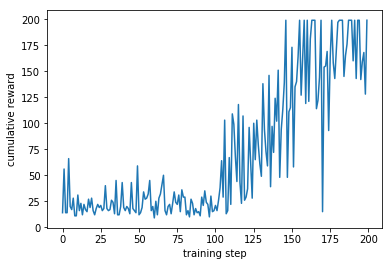

In [53]:
plt.xlabel('training step')
plt.ylabel('cumulative reward')
plt.plot(reward_set)
plt.show()

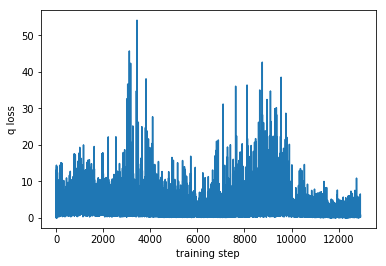

In [54]:
plt.xlabel('training step')
plt.ylabel('q loss')
plt.plot(q_loss_set)
plt.show()

In [55]:
print(action_output)
print(res)
print(ai)

[[0.447959   0.552041  ]
 [0.37747157 0.62252843]
 [0.8431073  0.15689275]
 [0.53240085 0.46759918]
 [0.61650205 0.3834979 ]
 [0.63148975 0.36851028]
 [0.52901036 0.47098967]
 [0.49586162 0.50413835]
 [0.13352136 0.86647856]
 [0.07817763 0.9218224 ]
 [0.51526624 0.48473376]
 [0.79007196 0.20992804]
 [0.4833936  0.5166064 ]
 [0.5726411  0.42735884]
 [0.6718261  0.32817385]
 [0.11770587 0.8822941 ]
 [0.08159494 0.91840506]
 [0.20823401 0.791766  ]
 [0.1453549  0.8546451 ]
 [0.58441716 0.41558287]
 [0.5498613  0.45013872]
 [0.6233469  0.37665308]
 [0.12144607 0.8785539 ]
 [0.2004193  0.7995807 ]
 [0.62433714 0.3756629 ]
 [0.24829496 0.75170505]
 [0.73701656 0.26298347]
 [0.1630069  0.83699316]
 [0.2719495  0.7280505 ]
 [0.3659703  0.6340297 ]
 [0.543827   0.45617294]
 [0.39450207 0.6054979 ]]
[0.552041   0.37747157 0.8431073  0.46759918 0.61650205 0.63148975
 0.47098967 0.50413835 0.13352136 0.9218224  0.51526624 0.79007196
 0.5166064  0.42735884 0.6718261  0.8822941  0.91840506 0.791766


### 参考资料

[1] [Simple Reinforcement Learning in Tensorflow: Part 1 - Two-armed Bandit](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149)

[2][Simple Reinforcement Learning with Tensorflow Part 1.5: Contextual Bandits](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-1-5-contextual-bandits-bff01d1aad9c)

[3][Simple Reinforcement Learning with Tensorflow: Part 2 - Policy-based Agents](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724)

[4]Sutton R S, Barto A G. Reinforcement learning: An introduction[M]. MIT press, 2018.

## 3 Model-Based RL

在本小节，我们对环境进行显式建模，做法是通过一个神经网络去学习实际环境的动态响应过程。以前一小节的CartPole为例，给定任意时刻的竖杆位置和拟执行的动作，我们希望构建模型预测竖杆的下个位置，显然这本身环境应该反馈的信息，现在我们准备提前获知，通过学习只有一个模型，我们可以基于模型而不是外界环境去训练智能体。在CartPole的案例中或许体现不出Model-Based的好处，因为其环境本就是模拟的，但在实际物理世界中，拥有一个环境的等价模型可为训练节省大量成本。

不同于仿真，物理世界需要花大量时间去探索，此外，在物理世界，连仿真复位这一基本操作都无法实现，这些都毫无疑问加大训练难度。而构建物理时间的模型就可以节省那些不必要的花费。借助环境模型，智能体得以预知其执行动作在虚拟环境中的结果，此时可以基于虚拟的环境模型和实际环境进行训练。当然，如果我们构造的环境模型足够真实精准，智能体也可以完全在这虚拟环境中训练，然后直接投入真实物理实际应用（交通信号控制案例可以考虑）。


下面基于TensforFlow实现Model-Based RL,依旧以CartPole为案例：

### 参考资料

[1][Simple Reinforcement Learning with Tensorflow: Part 3 - Model-Based RL](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-3-model-based-rl-9a6fe0cce99)